In [1]:
import os
import librosa
import pandas as pd
from glob import glob
import seaborn as sns
import random
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
base_dir = "/kaggle/input/movie2sub-dataset/dataset/train"

data = []
for dirname, _, _ in os.walk(base_dir):
    wav_files = sorted(glob(os.path.join(dirname, "*.wav")))
    txt_files = sorted(glob(os.path.join(dirname, "*.txt")))
    
    if wav_files and txt_files:
        data.extend(zip(wav_files, txt_files))

print(f"Total segments: {len(data)}")

Total segments: 1003


In [3]:
def process_audio(wav_file: str) -> tuple:
    """
    Process an audio file to compute signal-to-noise ratio (SNR), 
    FFT analysis, and energy distribution.

    Args:
        wav_file (str): Path to the .wav audio file.

    Returns:
        tuple: A tuple containing:
            - snr (float): Signal-to-Noise Ratio in decibels (dB).
            - freqs (numpy.ndarray): Frequency components of the audio signal.
            - fft (numpy.ndarray): Fast Fourier Transform of the audio signal.
            - energy (numpy.ndarray): Energy distribution across frames.
    """
    y, sr = librosa.load(wav_file, sr=None)
   
    signal_power = np.mean(y**2)
    noise_power = np.var(y - np.mean(y))
    snr = 10 * np.log10(signal_power / noise_power)

    fft = np.fft.fft(y)
    freqs = np.fft.fftfreq(len(fft), 1 / sr)

    frame_length = 2048
    hop_length = 512
    energy = np.array([
        np.sum(np.abs(y[i:i + frame_length]**2))
        for i in range(0, len(y), hop_length)
    ])
    
    return snr, freqs, fft, energy


In [4]:
def process_subtitles(txt_file: str) -> tuple:
    """
    Process a subtitle file in TXT format to extract text, character counts, and word counts.

    Args:
        txt_file (str): Path to the subtitle file (in TXT format).

    Returns:
        tuple: A tuple containing:
            - texts (list of str): List of subtitle texts (lines from the file).
            - char_counts (list of int): Number of characters in each line.
            - word_counts (list of int): Number of words in each line.
    """
    with open(txt_file, 'r', encoding='utf-8') as file:
        texts = file.readlines()
    
    texts = [line.strip() for line in texts if line.strip()]
    
    char_counts = [len(line.replace(" ", "").replace("\n", "")) for line in texts]
    word_counts = [len(text.split()) for text in texts]
    
    return texts, char_counts, word_counts

In [5]:
def plot_energy_distribution(wav_file: str):
    """
    Plots the energy distribution of an audio file.

    Args:
        wav_file (str): Path to the .wav audio file.
    """
    _, _, _, energy = process_audio(wav_file)
    
    frame_length = 2048
    hop_length = 512
    y, sr = librosa.load(wav_file, sr=None)
    times = np.arange(0, len(y), hop_length) / sr

    times = times[:len(energy)]

    dir_name = os.path.basename(os.path.dirname(wav_file))  
    file_name = os.path.splitext(os.path.basename(wav_file))[0]  

    formatted_name = f"{dir_name.replace(' ', '_').lower()}_{file_name}"


    plt.figure(figsize=(10, 6))
    plt.plot(times, energy, color='blue', linewidth=1)
    plt.title(formatted_name, fontsize=16)
    plt.xlabel("Time (s)")
    plt.ylabel("Energy")
    plt.grid(True)
    plt.savefig(f"{formatted_name}_ed.png", transparent=True)
    plt.show()

In [6]:
def plot_fft(wav_file: str):
    """
    Plots the FFT analysis of an audio file.

    Args:
        wav_file (str): Path to the .wav audio file.
    """
    _, freqs, fft, _ = process_audio(wav_file)

    dir_name = os.path.basename(os.path.dirname(wav_file))  
    file_name = os.path.splitext(os.path.basename(wav_file))[0] 

    formatted_name = f"{dir_name.replace(' ', '_').lower()}_{file_name}"
        
    plt.figure(figsize=(10, 6)) 
    plt.plot(freqs[:len(freqs)//2], np.abs(fft[:len(fft)//2]))
    plt.title(formatted_name, fontsize=16)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.savefig(f"{formatted_name}_fft.png", transparent=True)
    plt.show()

In [7]:
def plot_fft_and_energy_for_random_files(data: list, num_files: int = 5):
    """
    Randomly selects audio files from the data list and plots their FFT result and the energy distribution.

    Args:
        data (list): A list of tuples, where each tuple contains the paths for
                     a .wav file and its corresponding .srt/.txt file.
        num_files (int): Number of random files to plot (default is 5).
    """
    if len(data) < num_files:
        print(f"Not enough files to select {num_files}. Dataset contains only {len(data)} files.")
        return
        
    random_files = random.sample(data, num_files)
    
    for wav_file, _ in random_files:  
        print(f"Processing file: {wav_file}")  
        plot_fft(wav_file)  
        plot_energy_distribution(wav_file)
        

In [8]:
def plot_distributions(df: pd.DataFrame):
    """
    Plots the distribution of character counts and word counts from the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing columns for character and word counts.
    """
    plt.figure(figsize=(12, 6))
    sns.histplot(df["char_count_avg"], kde=True, bins=20, color="blue", alpha=0.7)
    plt.xlabel("Average Character Count", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.savefig('distribution_of_avg_char.png', transparent=True)
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.histplot(df["word_count_avg"], kde=True, bins=20, color="green", alpha=0.7)
    plt.xlabel("Average Word Count", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.savefig('distribution_of_avg_word.png', transparent=True)
    plt.show()


In [9]:
results = []
for wav_file, txt_file in data:
    snr, freqs, fft, energy = process_audio(wav_file)
    texts, char_counts, word_counts = process_subtitles(txt_file)
    
    results.append({
        "wav_file": wav_file,
        "txt_file": txt_file,
        "snr": snr,
        "char_count_avg": sum(char_counts) / len(char_counts),
        "word_count_avg": sum(word_counts) / len(word_counts),
        "energy_avg": sum(energy) / len(energy)
    })

df = pd.DataFrame(results)

Processing file: /kaggle/input/movie2sub-dataset/dataset/train/Jackie Brown (1997)/segment_000024.wav


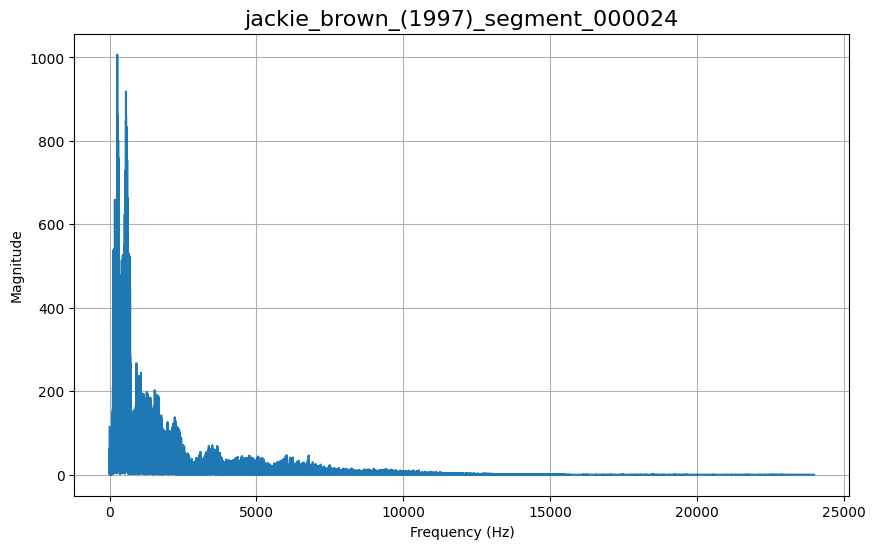

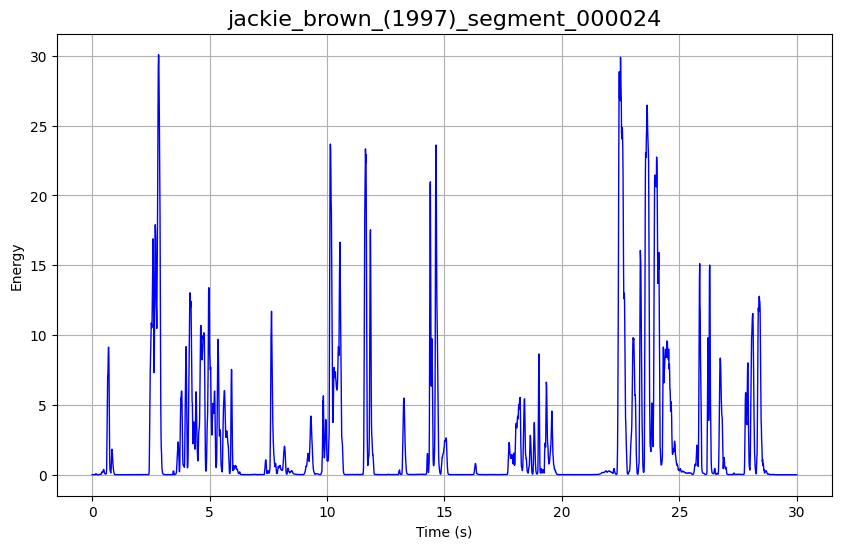

Processing file: /kaggle/input/movie2sub-dataset/dataset/train/Django Unchained (2012)/segment_000185.wav


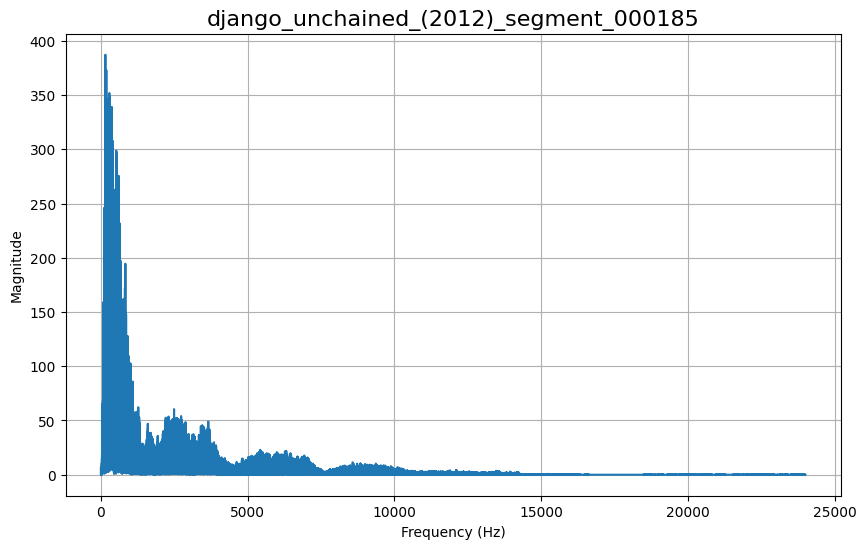

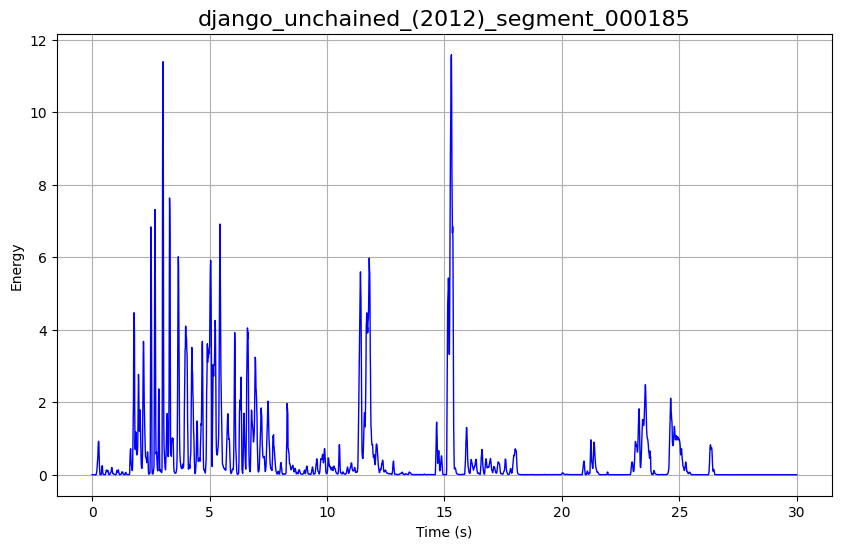

Processing file: /kaggle/input/movie2sub-dataset/dataset/train/Pulp Fiction (1994)/segment_000269.wav


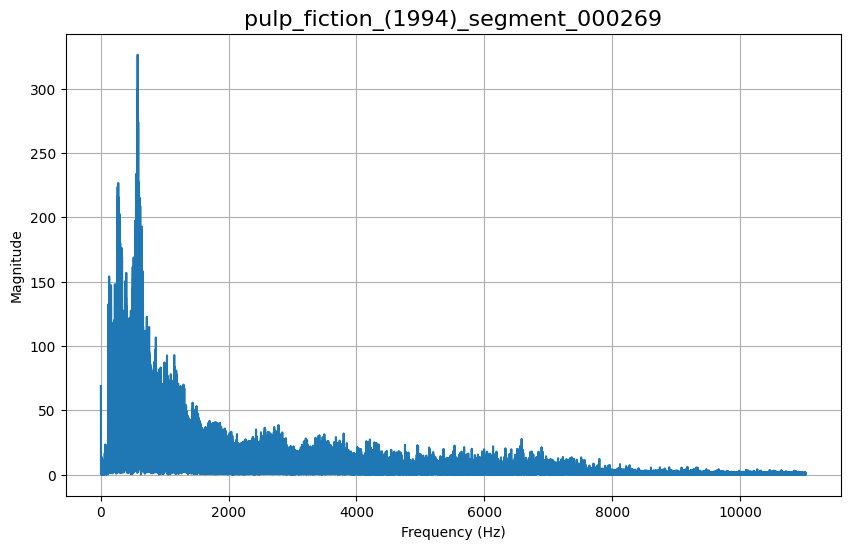

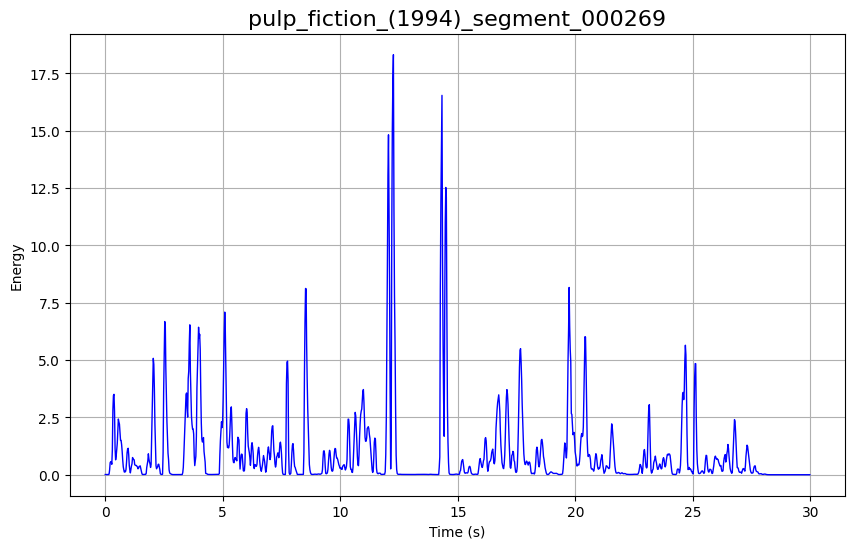

Processing file: /kaggle/input/movie2sub-dataset/dataset/train/Jackie Brown (1997)/segment_000238.wav


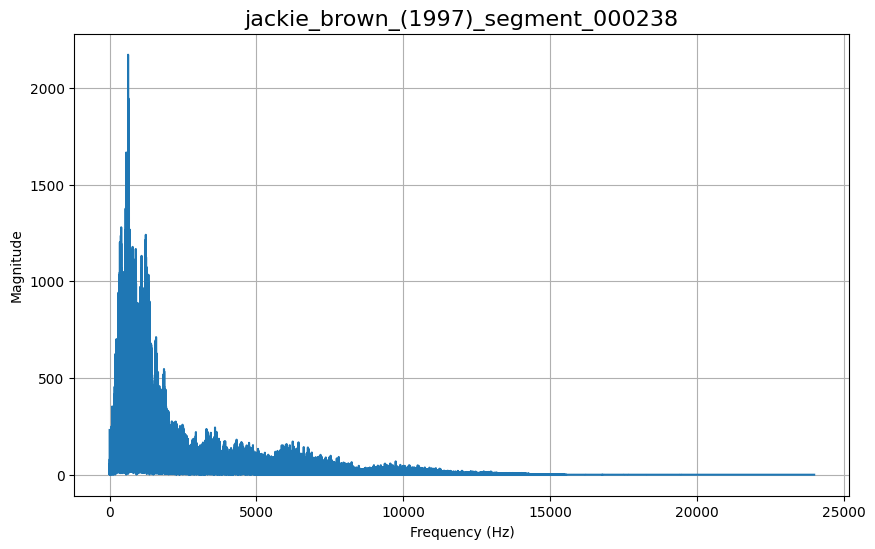

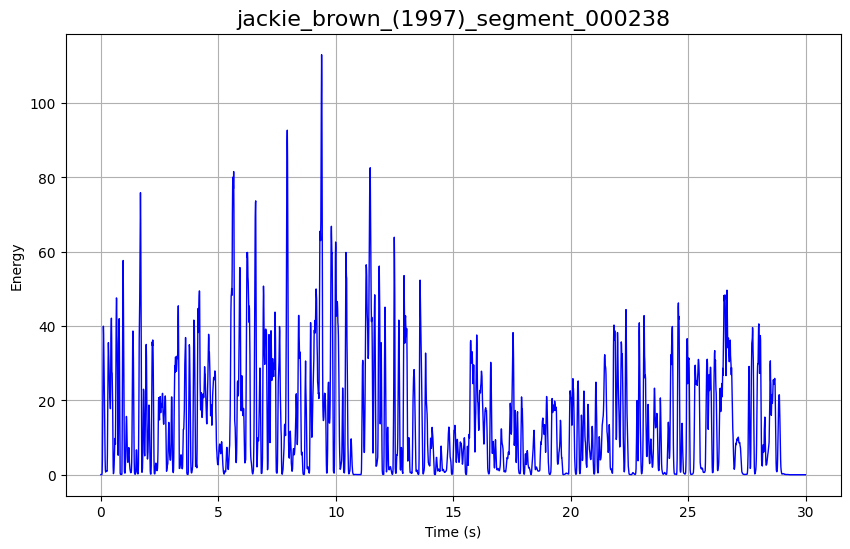

Processing file: /kaggle/input/movie2sub-dataset/dataset/train/Pulp Fiction (1994)/segment_000275.wav


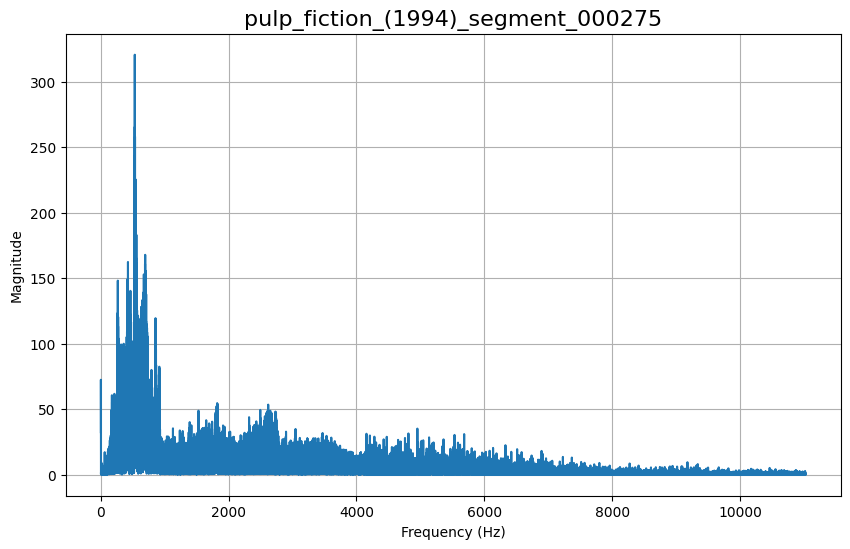

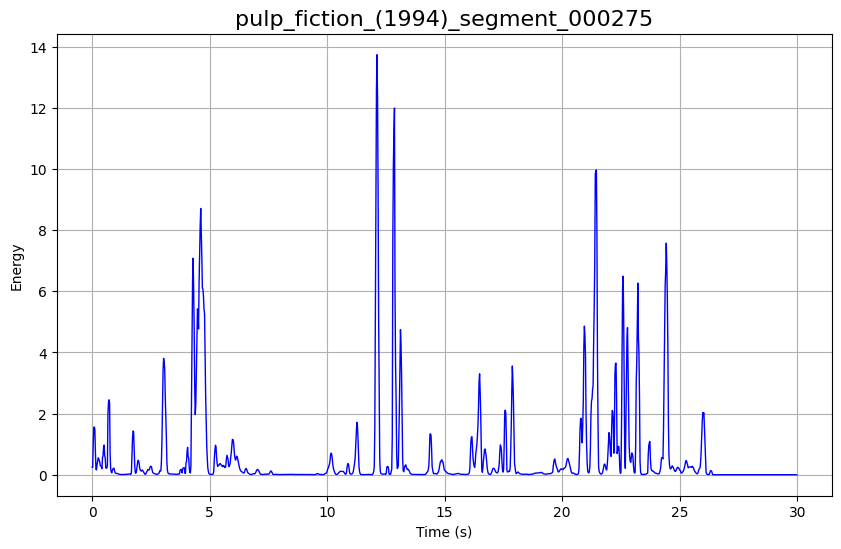

In [10]:
plot_fft_and_energy_for_random_files(data)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


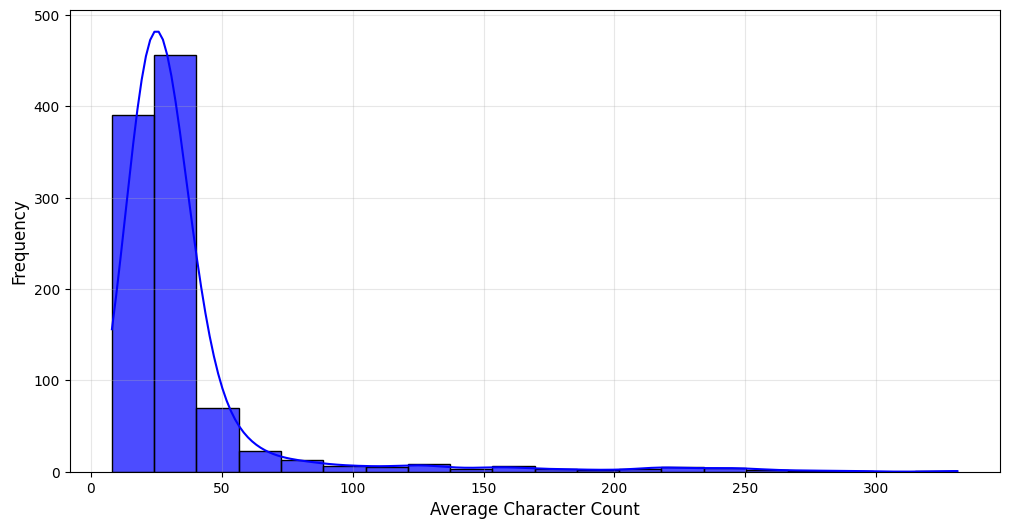

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


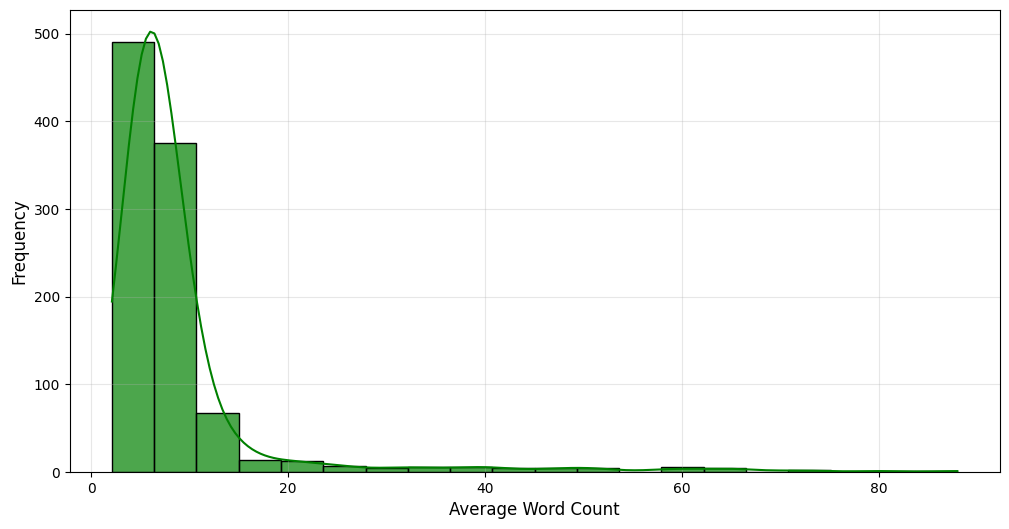

In [11]:
plot_distributions(df)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


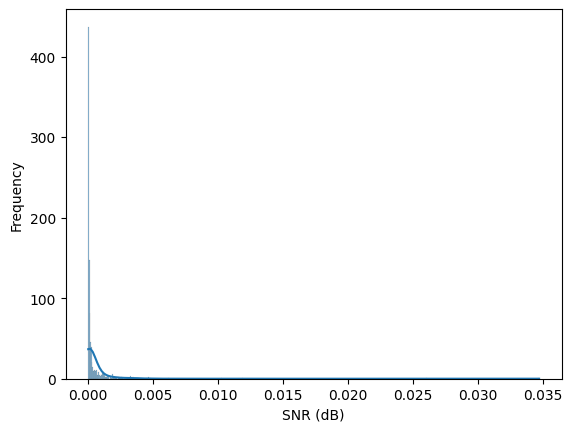

In [12]:
sns.histplot(df['snr'], kde=True)
plt.xlabel("SNR (dB)")
plt.ylabel("Frequency")
plt.savefig('distribution_of_snr.png', transparent=True)
plt.show()

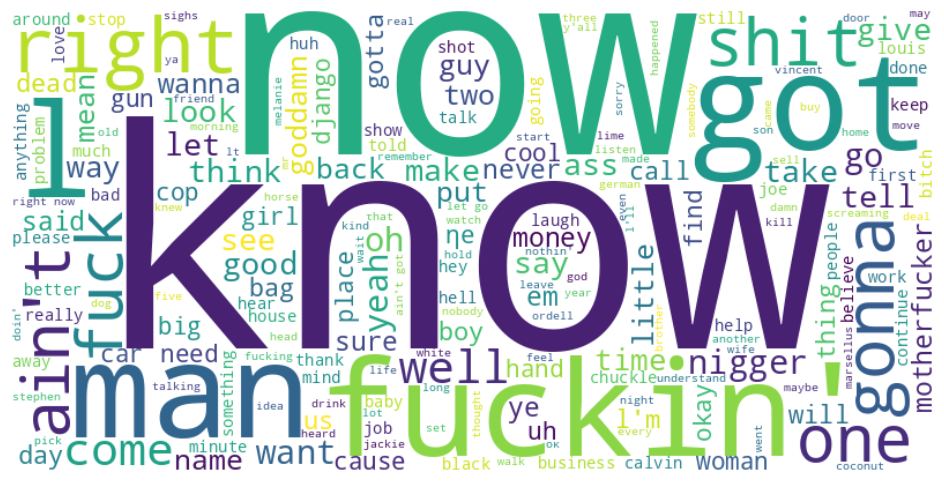

In [13]:
all_texts = ' '.join([' '.join(texts) for texts, _, _ in [process_subtitles(srt) for _, srt in data]])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_texts)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('word_cloud.png', transparent=True)
plt.show()